In [1]:
import torch
from torch import Tensor
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, Dataset
#from torchvision.transforms import 
import torchvision.transforms.functional as TF

from PIL import Image
import matplotlib.pyplot as plt
import sysconfig
from tqdm import tqdm
import numpy as np

In [2]:
torch.set_float32_matmul_precision('high')

In [3]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

In [4]:
device

'cuda'

# TODO

What should be the focus? 
from scratch or using pre created architectures? 

# Patch Embeddings

In [5]:
# C, H, W
H = 480
W = 480 
C = 3

def generate_rand_img(C: int = 3, H:int = 480, W:int = 480)-> Tensor:

    return torch.randn(C,H,W, dtype=torch.float32)

To handle 2D images, we reshape the image $ x ∈ \mathbb{R}^{H×W×C}$ into a sequence of flattened 2D patches $x_{p} ∈ \mathbb{R}^{N×(P^{2}·C)}$, where (H,W) is the resolution of the original
image,C = # of channels,(P,P) = resolution of each patch,and $N =HW/P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer.

In [6]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_channels:int = 3, embed_dim:int = 3):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size )**2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x


In [7]:
image = generate_rand_img()

In [8]:
test_img = TF.to_tensor(Image.open("raccoon.jpg").resize((900,900)))

In [9]:
def extract_patches(image : Tensor, patch_size:int):
    """"
    For visualization purposes, creates patches given an image Tensor.
    """
    patches = image.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
    patches = patches.contiguous().view(image.shape[0], -1, patch_size, patch_size)
    return patches


def visualize_patches(patches : Tensor):
    import matplotlib.pyplot as plt

    # 3 channels, 784 patches (28x28 after padding), each patch size 32x32

    num_patches = patches.shape[1]  # Total number of patches

    num_cols = int(num_patches**0.5)  # Number of columns in the grid
    num_rows = (num_patches + num_cols - 1) // num_cols  # Number of rows in the grid

    _, axs = plt.subplots(num_rows, num_cols, figsize=(4, 4))

    for i in range(num_rows):
        for j in range(num_cols):
            idx = i * num_cols + j
            if idx < num_patches:
                patch = patches[:, idx]  # Select the patch at index idx

                num_channels = patch.shape[0]

                # Visualize based on number of channels
                if num_channels == 1:  # Grayscale patch
                    axs[i, j].imshow(patch.squeeze().detach().cpu().numpy(), cmap='gray')  # Convert to numpy for imshow
                elif num_channels == 3:  # RGB patch
                    axs[i, j].imshow(patch.permute(1, 2, 0).detach().cpu().numpy())  # Convert to numpy and transpose to (H, W, C)
                else:
                    raise ValueError(f"Unsupported number of channels: {num_channels}")

                axs[i, j].axis('off')
            else:
                axs[i, j].axis('off')  # Turn off axis for empty subplots

    plt.tight_layout(pad=0.15)
    plt.show()


In [38]:
patches = extract_patches(test_img,64)
patches.shape

torch.Size([3, 196, 64, 64])

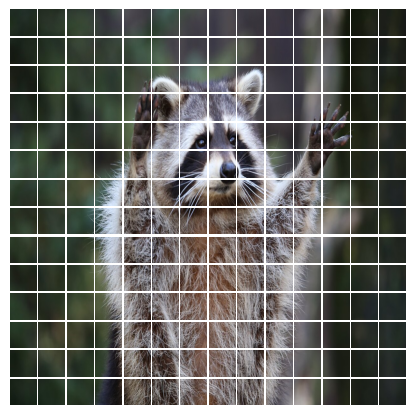

In [39]:
visualize_patches(patches)

# Patch Embeddings 

In [12]:
patch_emb = PatchEmbedding(900,32,3,8)
patches = patch_emb(test_img.unsqueeze(0))

In [13]:
test_img.shape

torch.Size([3, 900, 900])

# Position Embeddings

In [14]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super(PositionalEncoding, self).__init__()
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))
    
    def forward(self, x):
        return x + self.pos_embedding


# Transformer Encoder

In [15]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, num_layers: int, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout,bias= False)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
    def forward(self, x):
        return self.transformer_encoder(x)

# Vision Transformer

Model
ViT-Base ViT-Large ViT-Huge
Layers Hidden size D 12 768
24 1024 32 1280
MLP size Heads
Params
3072 12 86M 4096 16 307M 5120 16 632M

In [16]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=4, in_channels=3, embed_dim=768, num_heads=12, ff_dim=3072, num_layers=12, num_classes=10, dropout=0.1):
        super(VisionTransformer, self).__init__()
        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.positional_encoding = PositionalEncoding(self.patch_embedding.num_patches, embed_dim)
        self.transformer_encoder = TransformerEncoder(embed_dim, num_heads, ff_dim, num_layers, dropout)
        self.classifier = nn.Linear(embed_dim, num_classes, bias= False)
    
    def forward(self, x):
        x = self.patch_embedding(x)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Global average pooling
        x = self.classifier(x)
        return x

# CIFAR10

In [18]:
import torch
from torchvision import datasets, transforms

# Define transformations for the input data
transform = transforms.Compose([
    #transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load your dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


In [19]:
import os
import math

def get_folder_size(folder_path :os.PathLike) -> str:
    total_size = 0
    for dirpath, _, filenames in os.walk(folder_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)

            if not os.path.islink(file_path):
                total_size += os.path.getsize(file_path)

    if total_size == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB")
    i = int(math.floor(math.log(total_size, 1024)))
    p = math.pow(1024, i)
    s = round(total_size / p, 2)
    return f"{s} {size_name[i]}"


folder_path = './data'
size_in_bytes = get_folder_size(folder_path)
print(f"Folder size: {size_in_bytes}")

Folder size: 340.19 MB


In [21]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F

# Initialize the model, loss function, optimizer, and learning rate scheduler
model = VisionTransformer(
    img_size=32,
    patch_size=2,
    embed_dim=256, num_heads=8, ff_dim=512, num_layers=6, dropout= 0.2
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

/home/rodz/Documents/uba/Vision-Transformers/venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [22]:
model = model.to(device)

In [23]:
model = torch.compile(model)

In [24]:
def count_parameters(model: nn.Module) -> int:
    """
    Count the number of trainable parameters in a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model.

    Returns:
        int: The total number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad) / 1_000_000

In [25]:
torch.cuda.empty_cache()

In [26]:
count_parameters(model)

3.220224

In [27]:
from trainer import Trainer

In [28]:
trainer = Trainer(model, train_loader,test_loader,criterion,optimizer, device)

In [29]:
num_epochs = 10
for epoch in range(num_epochs):

    trainer.train_model(use_amp=True)
    
    #scheduler.step()

  0%|          | 0/98 [00:00<?, ?it/s]

loss 1.31038: 100%|██████████| 98/98 [00:21<00:00,  4.59it/s]


# Testing

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [31]:
def evaluate_model(model, data_loader):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            outputs = model(torch.tensor(images,device=device, dtype=torch.float32))
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    
    return accuracy, precision, recall, f1

# Evaluate the model
accuracy, precision, recall, f1 = evaluate_model(model, test_loader)

  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_22773/1158528796.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images,device=device, dtype=torch.float32))
  5%|▌         | 1/20 [00:05<01:48,  5.71s/it]/tmp/ipykernel_22773/1158528796.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images,device=device, dtype=torch.float32))
100%|██████████| 20/20 [00:09<00:00,  2.18it/s]


In [32]:
print(accuracy, precision, recall, f1)

0.5432 0.5547643415322058 0.5431999999999999 0.5424031022143789


In [33]:
#trainer.eval_model()

In [34]:
train_dataset.data[0].shape

(32, 32, 3)

In [35]:
# for test in test_loader:
#     print(test[0].shape)
#     break

In [36]:
#model(torch.tensor(test[0],device=device, dtype=torch.float32))

  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_22773/3880358000.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(inputs,device=device, dtype=torch.float32))


  0%|          | 0/20 [00:00<?, ?it/s]


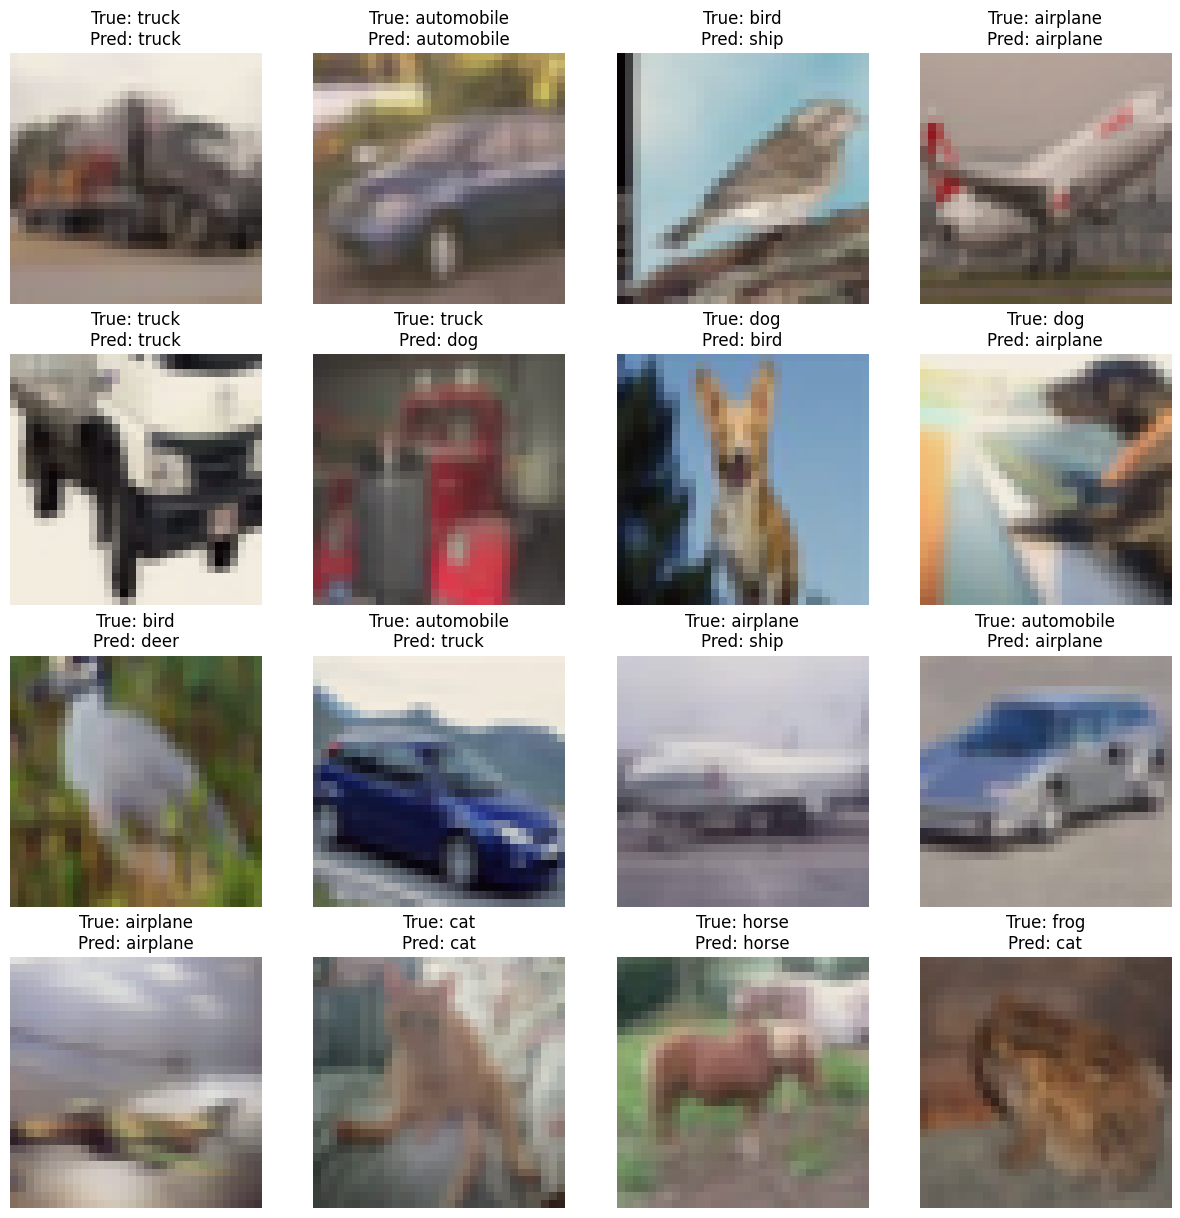

In [37]:
class_names = test_dataset.classes

# Function to visualize the classification results
def visualize_classification(model, data_loader, class_names, num_images=16):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(data_loader)):
            outputs = model(torch.tensor(inputs,device=device, dtype=torch.float32))
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 4, 4, images_so_far)
                ax.axis('off')
                ax.set_title(f'True: {class_names[labels[j]]}\nPred: {class_names[preds[j]]}')
                img = inputs[j].cpu().numpy().transpose((1, 2, 0))
                img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
                img = np.clip(img, 0, 1)
                ax.imshow(img)

                if images_so_far == num_images:
                    return

# Visualize the classification results
visualize_classification(model, test_loader, class_names, num_images=16)
plt.show()